사용한 모델은 현재 심사중인 ConvMixer논문입니다.
(https://openreview.net/forum?id=TVHS5Y4dNvM)


In [52]:
import torch

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [53]:
RANDOM_SEED = 1234
torch.manual_seed(RANDOM_SEED)

In [54]:
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore') # 디폴트 경고 문구를 제거 로직

train = pd.read_csv('./train/train_data.csv')
train.head()
print('트레인셋 데이터 개수 :', len(train))

트레인셋 데이터 개수 : 5000


In [55]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [56]:
# 트레인에 사용할 numpy 이미지 어레이와, label 어레이를 생성합니다.
file_dir = './train/'

images = []

for image_name in train['filen_name']:
    image = np.array(Image.open((file_dir+image_name)))
    images.append(image)

labels = train['label']

In [57]:
# 1체널 이미지를 3체널로 변경합니다.
print(np.array(images).shape)

X = np.expand_dims(np.array(images), -1)
X = np.concatenate([X,X,X],-1)
y = np.array(train['label'])

print(X.shape, y.shape)

(5000, 28, 28)
(5000, 28, 28, 3) (5000,)


In [58]:
del images

In [59]:
from sklearn.model_selection import train_test_split
VALID_SIZE = 1000

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = VALID_SIZE, random_state=RANDOM_SEED)

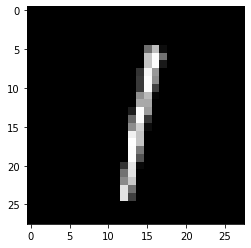

1


In [60]:
plt.imshow(X_train[0])
plt.show()
print(y_train[0])

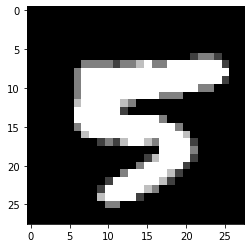

5


In [61]:
plt.imshow(X_valid[0])
plt.show()
print(y_valid[0])

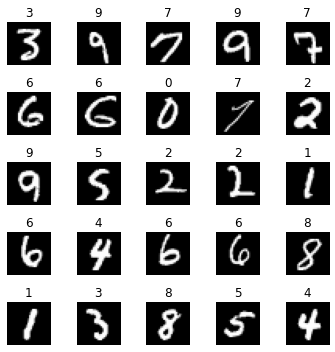

In [62]:
nrows, ncols = 5,5

indices = np.random.randint(len(X), size=(nrows, ncols))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5,5))
for i in range(nrows):
    for j in range(ncols):
        idx = indices[i][j]
        ax[i][j].imshow(X[idx], cmap='gray')
        ax[i][j].set_title(f"{y[idx]}")
        ax[i][j].axis('off')
plt.tight_layout()
plt.show()

In [63]:
import torch
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models

In [64]:
CROP = True
ROTATION = True
NORMALIZATION = True
PERSPECTIVE = True

In [65]:
def get_transform(train=True):
    t = list()
    t.append(transforms.ToTensor())
    if CROP and train:
        t.append(transforms.RandomResizedCrop(size=28,scale=(.35, 1.),ratio=(.5, 2),interpolation=transforms.InterpolationMode.NEAREST))
    if ROTATION and train:
        t.append(transforms.RandomRotation(
            degrees=25,interpolation=transforms.InterpolationMode.NEAREST))
    if PERSPECTIVE and train:
        t.append(transforms.RandomPerspective(distortion_scale=.55,p=.75,interpolation=transforms.InterpolationMode.NEAREST))
    if NORMALIZATION:
        t.append(transforms.Normalize(mean=(.5),std=(.5)))
    return transforms.Compose(t)

In [66]:
class CustomDataset(Dataset):
    def __init__(self, X, y=None, transform=None, target_transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self,idx):
        inputs = self.X[idx]
        inputs = inputs[:27,:27]
        if transform:
            inputs = self.transform(inputs)
        if self.y is not None:
            labels = self.y[idx]
            if self.target_transform:
                labels = self.target_transform(labels)
                return inputs, labels
        return inputs

In [67]:
transform = get_transform()
transform_test = get_transform(train=False)

In [68]:
transformed_train = CustomDataset(X=X_train, y=y_train, transform=transform)
transformed_valid = CustomDataset(X=X_valid, y=y_valid, transform=transform_test)

print(len(transformed_train))
print(len(transformed_valid))

4000
1000


In [69]:
BATCH_SIZE = 128

train_loader = DataLoader(transformed_train, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(transformed_valid, batch_size=BATCH_SIZE, shuffle=False)

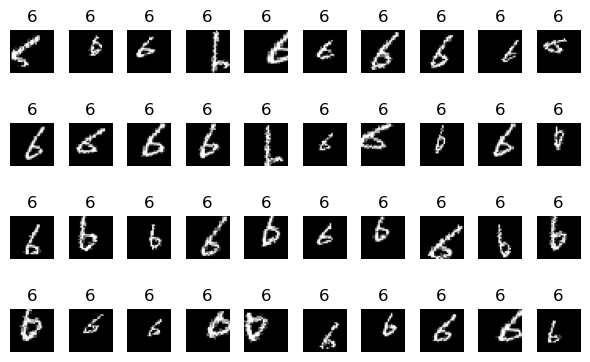

In [70]:
transform = get_transform()
idx = np.random.randint(len(X))

fig, ax = plt.subplots(nrows=4, ncols=10,dpi=100)
for i in range(4):
    for j in range(10):
        ax[i][j].imshow(np.squeeze(transform(X[idx]))[0], cmap='gray')
        ax[i][j].axis('off')
        ax[i][j].set_title(f"{y[idx]}")
plt.tight_layout()
plt.show()

In [71]:
def compute_acc(true, pred): # acc 계산
    return sum(true == pred) / len(true)

In [72]:
#  Returns a bool indicating if CUDA is currently available.
torch.cuda.is_available()
#  True
 
#  Returns the index of a currently selected device.
torch.cuda.current_device()
#  0
 
#  Returns the number of GPUs available.
torch.cuda.device_count()
#  1
 
#  Gets the name of a device.
torch.cuda.get_device_name(0)
#  'GeForce GTX 1060'
 
#  Context-manager that changes the selected device.
#  device (torch.device or int) – device index to select. 
torch.cuda.device(0)

In [73]:
import torch.nn.functional as F

In [74]:
import torch.nn as nn

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
  
    def forward(self, x):
        return self.fn(x) + x

def ConvMixer(dim, depth, kernel_size=3, patch_size=3, n_classes=10):
    return nn.Sequential(
      nn.Conv2d(3, dim, kernel_size = patch_size, stride = patch_size),
      nn.GELU(),
      nn.BatchNorm2d(dim),
      *[nn.Sequential(
          Residual(nn.Sequential(
              nn.Conv2d(dim, dim, kernel_size, groups=dim, padding="same"),
              nn.GELU(),
              nn.BatchNorm2d(dim)
          )),
          nn.Conv2d(dim, dim, kernel_size=1),
          nn.GELU(),
          nn.BatchNorm2d(dim)
      ) for i in range(depth)],
      nn.AdaptiveAvgPool2d((1,1)),
      nn.Flatten(),
      nn.Linear(dim, n_classes)
  )

In [75]:
torch.cuda.empty_cache()

model = ConvMixer(dim=2**11, depth=20, kernel_size=3, patch_size=3, n_classes=10).to(0) # 모델 선언 

In [76]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3) # optimizer 선언 (Adam)
ce_loss = nn.CrossEntropyLoss() # loss함수 선언 cross entrophy loss

In [77]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    train_losses = list()
    for batch, (X, Y) in enumerate(dataloader):

        X = X.to(device)
        labels = Y.to(device)
        # Prediction & loss Calculation
        preds = model(X)

        loss = ce_loss(preds, labels) # loss 계산

    # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item()) # 각 배치마다의 loss를 losses 리스트에 append한다

    if batch % 10 == 0: # 10번째 배치(100개) 마다의 loss를 출력한다
        loss, current = loss.item(), batch*len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    print(f"Train Loss : {np.mean(train_losses):>8f}") # 트레인 루프 종료시 평균 LOSS를 출력한다.
    return train_losses

In [78]:
def valid_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    valid_losses = list()
    with torch.no_grad():
        for batch, (X, Y) in enumerate(dataloader):
            X = X.to(device)
            labels = Y.to(device)
            preds = model(X)
            loss = loss_fn(preds,labels).item()
            valid_losses.append(loss)
    print(f"Valid Loss : {np.mean(valid_losses):>8f}") # 테스트 루프 종료시 평균 LOSS를 출력한다.

    acc = compute_acc(labels.detach().cpu().numpy(), preds.detach().cpu().numpy().argmax(-1))
    print(f"Valid accuracy : {acc:>8f}") # 테스트 루프 종료시 평균 LOSS를 출력한다.

    return valid_losses, acc

In [79]:
MODEL_SAVE_PATH = './TEMP.pth'

In [80]:
class EarlyStopping:
#       """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
#       """
#       Args:
#           patience (int): validation loss가 개선된 후 기다리는 기간
#                           Default: 3
#           verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
#                           Default: False
#           delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
#                           Default: 0
#           path (str): checkpoint저장 경로
#                           Default: 'checkpoint.pt'
#       """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0 
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}\n')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...\n')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [81]:
import math
import time
import datetime

train_loss_per_epoch = list()
valid_loss_per_epoch = list()
accuracy = list()

start = time.time()  # 시작 시간 저장

early_stopping = EarlyStopping(patience = 30, verbose=True, path=MODEL_SAVE_PATH) # patience번 test loss가 떨어지지 않는다면 stop 시키자
torch.cuda.empty_cache()
for t in range(500):
    print(f"Epoch {t+1}\n-------------------------------")
  # --- 모델 트레이닝 --- #
    model.train() 
    train_losses = train_loop(train_loader, model, ce_loss, optimizer)

    # --- 모델 평가 --- #
    model.eval() 
    valid_losses, acc = valid_loop(valid_loader, model, ce_loss)

    # --- 로스 저장 부분 --- #
    train_loss = np.mean(train_losses) # Epoch 마다의 평균 train_loss
    valid_loss = np.mean(valid_losses) # Epoch 마다의 평균 test_loss

    train_loss_per_epoch.append(train_loss) # 리스트에 저장
    valid_loss_per_epoch.append(valid_loss) # 리스트에 저장
    accuracy.append(np.mean(acc))

    # --- 얼리스탑 체크 --- #
    early_stopping(valid_loss, model)

    if early_stopping.early_stop:
        print('Early stopping')
        break

print("Done!")

end = time.time()
sec = (end - start) # 종료시간 계산
result = datetime.timedelta(seconds=sec)
result_list = str(datetime.timedelta(seconds=sec)).split(".")
print("time :", result_list[0])

Epoch 1
-------------------------------


ValueError: too many values to unpack (expected 2)

In [86]:
plt.plot(list(range(0, len(train_loss_per_epoch))), train_loss_per_epoch)
plt.ylabel('Error')
plt.xlabel('Iteration')
plt.show()

ValueError: too many values to unpack (expected 2)

In [87]:
plt.plot(list(range(0, len(valid_loss_per_epoch))), valid_loss_per_epoch)
plt.ylabel('Error')
plt.xlabel('Iteration')
plt.show()

In [ ]:
plt.plot(list(range(0, len(accuracy))), accuracy)
plt.ylabel('Accuracy')
plt.xlabel('Iteration')
plt.show()

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
test_df = pd.read_csv('./test/test_data.csv') # test_data.csv 불러오기
test_file_dir = './test/test/'

In [ ]:
test_images = []
for image_name in test_df['file_name']:
  image = np.array( Image.open(test_file_dir + image_name) )
  test_images.append(image)

X_test = np.expand_dims(np.array(test_images), -1)
X_test = np.concatenate([X_test,X_test,X_test], -1)

print(X_test.shape)

In [ ]:
TEST_BATCH_SIZE = 16

transform_test = get_transform(train=False)
transformed_test = CustomDataset(X=X_test, transform=transform_test)

test_loader = DataLoader(transformed_test, batch_size=TEST_BATCH_SIZE, shuffle=False)

In [ ]:
from tqdm import tqdm
import math
import time
import datetime
# 메모리 줄이기 위해 train, valid loader와 dataset 삭제
#del train_loader
#del transformed_train

#del valid_loader
#del transformed_valid

torch.cuda.empty_cache()

preds = None

model.load_state_dict(torch.load(MODEL_SAVE_PATH)) #최적 모델 파라미터 어태칭
model.eval() 

start = time.time()  # 시작 시간 저장

for test_batch in tqdm(test_loader):
    test_batch = test_batch.to(0)
    output = model(test_batch)
    digit_pred = output.detach().cpu().numpy().argmax(-1)

    if preds is None:
        preds = digit_pred
    else:
        preds = np.concatenate([preds, digit_pred])


end = time.time()
sec = (end - start) # 종료시간 계산
result = datetime.timedelta(seconds=sec)
result_list = str(datetime.timedelta(seconds=sec)).split(".")
print("time :", result_list[0])